In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -m -p scipy,numpy,sklearn

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
CPython 3.5.2
IPython 5.1.0

scipy 0.18.1
numpy 1.11.2
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.1.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
from sklearn import datasets
diabetes = datasets.load_diabetes()

In [3]:
class SingleNeuron(object):

    def __init__(self):
        self._w = 0         # 가중치 w
        self._b = 0         # 바이어스 b
        self._w_grad = 0
        self._b_grad = 0
        self._x = 0         # 입력값 x

    def set_params(self, w, b):
        """가중치와 바이어스를 저장합니다."""
        self._w = w
        self._b = b

    def forpass(self, x):
        """정방향 수식 w * x + b 를 계산하고 결과를 리턴합니다."""
        self._x = x
        _y_hat = self._w * self._x + self._b
        return _y_hat

    def backprop(self, err, lr=0.1):
        """에러를 입력받아 가중치와 바이어스의 변화율을 곱하고 평균을 낸 후 감쇠된 변경량을 저장합니다."""
        m = len(self._x)
        self._w_grad = lr * np.sum(err * self._x) / m
        self._b_grad = lr * np.sum(err * 1) / m

    def update_grad(self, l2=0):
        """계산된 파라메타의 변경량을 업데이트하여 새로운 파라메타를 셋팅합니다."""
        self.set_params(self._w + self._w_grad - l2 * self._w, self._b + self._b_grad)

    def fit(self, X, y, n_iter=10, lr=0.1, cost_check=False, l2=0):
        """정방향 계산을 하고 역방향으로 에러를 전파시키면서 모델을 최적화시킵니다."""
        cost = []
        for i in range(n_iter):
            y_hat = self.forpass(X)
            error = y - y_hat
            self.backprop(error, lr)
            self.update_grad(l2/len(y))
            if cost_check:
                cost.append(np.sum(np.square(y - y_hat))/len(y))
        return cost

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.data[:, 2], diabetes.target, \
                                                    test_size=0.1, random_state=10)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(397,) (45,) (397,) (45,)


In [7]:
n1 = SingleNeuron()

In [8]:
n1.set_params(5, 1)
n1.fit(X_train, y_train, 30000)
print('Final W', n1._w)
print('Final b', n1._b)

Final W 946.291309007
Final b 151.784075857


In [9]:
y_hat = n1.forpass(X_test)
print(np.sum(np.square(y_test - y_hat))/len(y_test))

3330.44578806


In [10]:
from sklearn import metrics
print(metrics.mean_squared_error(y_test, y_hat))

3330.44578806


In [11]:
from sklearn import linear_model

sgd_regr = linear_model.SGDRegressor(n_iter=30000, penalty='none')
sgd_regr.fit(X_train.reshape(-1, 1), y_train)
print('Coefficients: ', sgd_regr.coef_, sgd_regr.intercept_)

Coefficients:  [ 945.04189399] [ 151.77515304]


In [12]:
y_hat = sgd_regr.predict(X_test.reshape(-1, 1))
print(metrics.mean_squared_error(y_test, y_hat))

3330.62098941


In [13]:
costs = []
learning_rate = [1.999, 1.0, 0.1]
for lr in learning_rate:
    n1.set_params(5, 1)
    costs.append([])
    costs[-1] = n1.fit(X_train, y_train, 2000, lr, True)

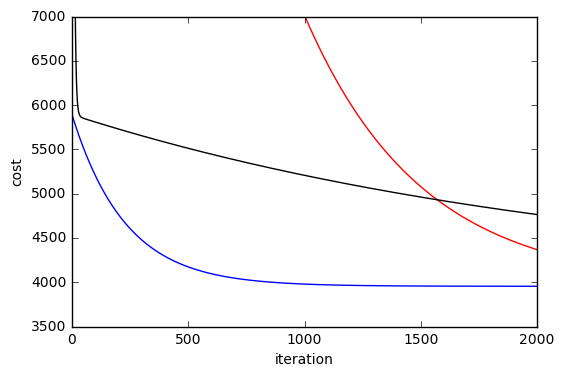

In [14]:
for i, color in enumerate(['red', 'blue', 'black']):
    plt.plot(list(range(2000)), costs[i], color=color)
plt.ylim(3500, 7000)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

In [15]:
learning_rate = [1.2, 1.0, 0.8]
for lr in learning_rate:
    n1.set_params(5, 1)
    n1.fit(X_train, y_train, 2000, lr)
    y_hat = n1.forpass(X_test)
    print(metrics.mean_squared_error(y_test, y_hat))

3330.8154743
3331.74740789
3335.16964255


In [16]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=10)

In [17]:
learning_rate = [1.2, 1.0, 0.8]
for lr in learning_rate:
    validation_errors = 0
    for train, validation in kf.split(X_train):
        n1.fit(X_train[train], y_train[train], 2000, lr)
        y_hat = n1.forpass(X_train[validation])
        validation_errors += metrics.mean_squared_error(y_train[validation], y_hat)
    print(validation_errors/5)

4006.76059166
4006.43602691
4005.6619766


In [18]:
costs = []
for l2 in [0, 0.1]:
    costs.append([])
    n1.set_params(5, 1)
    costs[-1] = n1.fit(X_train, y_train, 2000, 1.0, cost_check=True, l2=l2)
    print('Final W', n1._w)
    print('Final b', n1._b)
    y_hat = n1.forpass(X_test)
    print(metrics.mean_squared_error(y_test, y_hat))

Final W 935.654492908
Final b 151.779158984
3331.74740789
Final W 842.993426674
Final b 151.736424518
3371.75796633


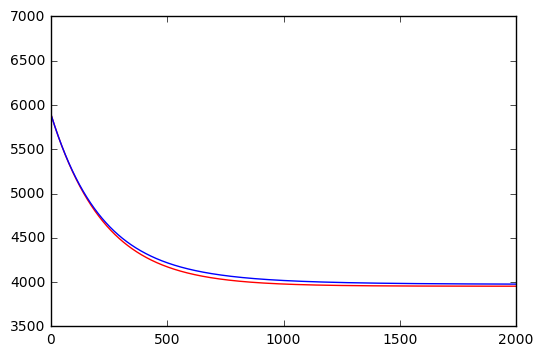

In [19]:
for i, color in enumerate(['red', 'blue']):
    plt.plot(list(range(2000)), costs[i], color=color)
plt.ylim(3500, 7000)
plt.show()